## Using sklearn library for convolutional neural network

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
import PIL
import matplotlib.pyplot as plt
from typing import Tuple
from tqdm import tqdm
from PIL import Image
from helper_func import load_image, PIL_resize, PIL_resize_ws
from matplotlib.pyplot import imshow
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from helper_func import generate_confusion_matrix
import joblib

In [7]:
train = pd.read_csv('garbage-classification/zero-indexed-files.csv')
data = []
labels = train['Label'].values
for i in tqdm(range(train.shape[0])):
    img = load_image('garbage-classification/data/'+train['Name'][i]+'.jpg')
    img = PIL_resize_ws(img, 128)
    data.append(img)
data = np.asarray(data)
print("Training data size: ", data.shape)
print("Training label size: ", labels.shape)

100%|██████████| 2527/2527 [00:13<00:00, 186.39it/s]


Training data size:  (2527, 128, 128, 3)
Training label size:  (2527,)


## Generating training dataset and testing dataset based on a custom ratio

In [9]:
num_classified = 6
classified_name = ["glass", "paper", "cardboard", "plastic", "metal", "trash"]

classified_start_idx = np.zeros(num_classified, dtype=int)
classified_size = np.zeros(num_classified, dtype=int)
temp_count = 0
for i in range(num_classified):
    classified_start_idx[i] = temp_count
    size = np.count_nonzero(labels == i)
    classified_size[i] = size
    temp_count += size

## Defining the split between training dataset and testing dataset
training_ratio = 0.9
training_data_size = np.array(training_ratio*classified_size, dtype=int)
testing_data_size = classified_size - training_data_size

## Randomly select (num*training_ratio) from each classes in order to prevent one class from dominating the dataset by accident
training_idx = np.array([], dtype=int)
testing_idx = np.array([], dtype=int)
for i in range(num_classified):
    selected = np.random.choice(classified_size[i],size=training_data_size[i],  replace=False)
    each = np.arange(classified_size[i])
    training_idx = np.concatenate((training_idx, selected+classified_start_idx[i]), axis=0)
    testing_idx = np.concatenate((testing_idx, np.setdiff1d(each, selected)+classified_start_idx[i]), axis=0)

## Randomly shuffle the indices we pick
training_idx = np.random.permutation(training_idx)
testing_idx = np.random.permutation(testing_idx)

labels = train['Label'].values
training_data = data[training_idx]
training_labels = labels[training_idx]
testing_data = data[testing_idx]
testing_labels = labels[testing_idx]

## convert shape (N,H,W,C) to (N,C,H,W)
training_data = np.swapaxes(training_data, 1,3)
training_data = np.swapaxes(training_data, 2,3)
testing_data = np.swapaxes(testing_data, 1,3)
testing_data = np.swapaxes(testing_data, 2,3)

## Convert numpy to torch tensor
training_data = torch.from_numpy(training_data)
training_labels = torch.from_numpy(training_labels)
testing_data = torch.from_numpy(testing_data)
testing_labels = torch.from_numpy(testing_labels)
print("Training data shape: ", training_data.shape)
print("Training labels shape: ", training_labels.shape)
print("Testing data shape: ", testing_data.shape)
print("Testing labels shape: ", testing_labels.shape)

## In order to fit to sklearn MLP, we need to flatten the image
r_training_data = torch.reshape(training_data, (training_data.shape[0], -1))
r_testing_data = torch.reshape(testing_data, (testing_data.shape[0], -1))

Training data shape:  torch.Size([2271, 3, 128, 128])
Training labels shape:  torch.Size([2271])
Testing data shape:  torch.Size([256, 3, 128, 128])
Testing labels shape:  torch.Size([256])


  0%|          | 0/9 [00:00<?, ?it/s]/Users/mehulgoel/anaconda3/envs/HackCMU/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Normalized confusion matrix


/Users/mehulgoel/Documents/HACKS-CMU_2023/Eco-Bin/src/helper_func.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(# ... and label them with the respective list entries


<Figure size 640x480 with 0 Axes>

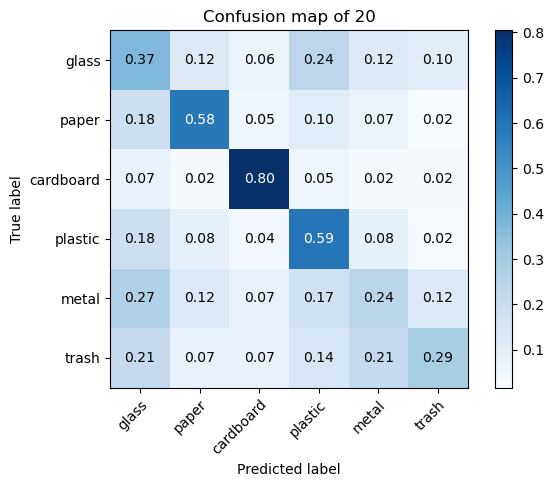

 11%|█         | 1/9 [04:23<35:07, 263.45s/it]

#hidden units 20	Loss:  0.4824666892384081
#hidden units 20	Accuracy:  0.5078125


/Users/mehulgoel/anaconda3/envs/HackCMU/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/mehulgoel/Documents/HACKS-CMU_2023/Eco-Bin/src/helper_func.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(# ... and label them with the respective list entries


Normalized confusion matrix


<Figure size 640x480 with 0 Axes>

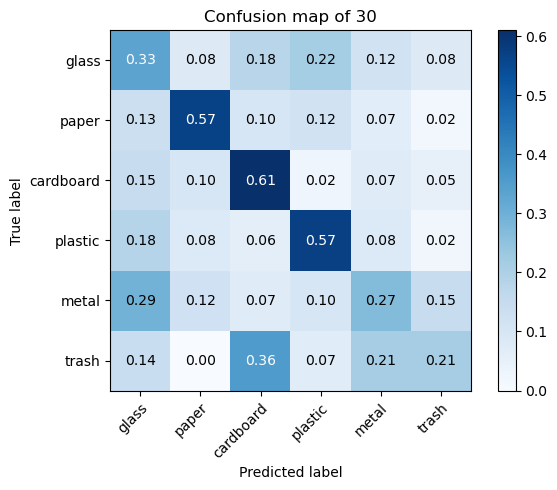

 22%|██▏       | 2/9 [08:56<31:25, 269.33s/it]

#hidden units 30	Loss:  0.567371298944177
#hidden units 30	Accuracy:  0.4609375


/Users/mehulgoel/anaconda3/envs/HackCMU/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Normalized confusion matrix


/Users/mehulgoel/Documents/HACKS-CMU_2023/Eco-Bin/src/helper_func.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(# ... and label them with the respective list entries


<Figure size 640x480 with 0 Axes>

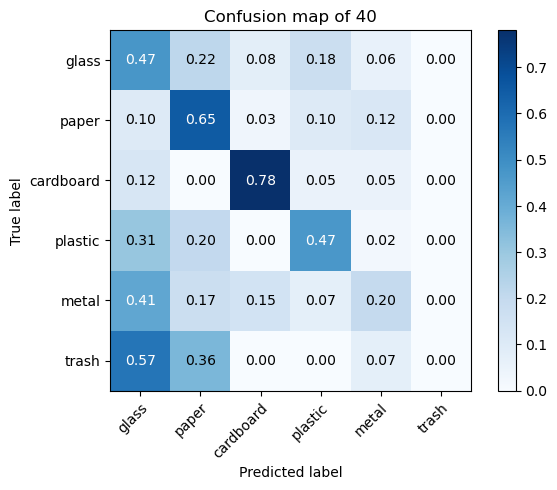

 33%|███▎      | 3/9 [13:57<28:22, 283.67s/it]

#hidden units 40	Loss:  0.8449556054322847
#hidden units 40	Accuracy:  0.4921875


/Users/mehulgoel/anaconda3/envs/HackCMU/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/mehulgoel/Documents/HACKS-CMU_2023/Eco-Bin/src/helper_func.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(# ... and label them with the respective list entries


Normalized confusion matrix


<Figure size 640x480 with 0 Axes>

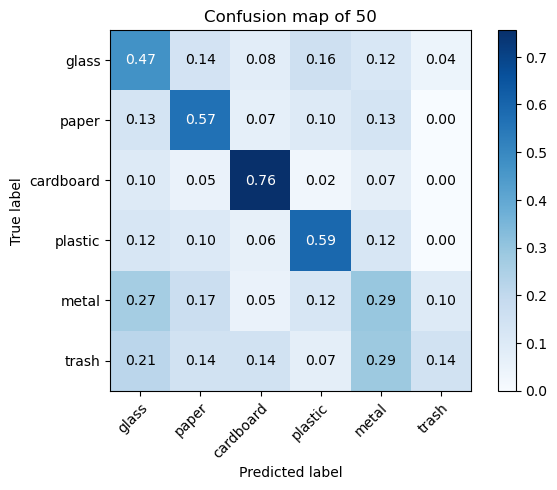

 44%|████▍     | 4/9 [18:32<23:20, 280.17s/it]

#hidden units 50	Loss:  0.512030643614902
#hidden units 50	Accuracy:  0.515625


/Users/mehulgoel/anaconda3/envs/HackCMU/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/mehulgoel/Documents/HACKS-CMU_2023/Eco-Bin/src/helper_func.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(# ... and label them with the respective list entries


Normalized confusion matrix


<Figure size 640x480 with 0 Axes>

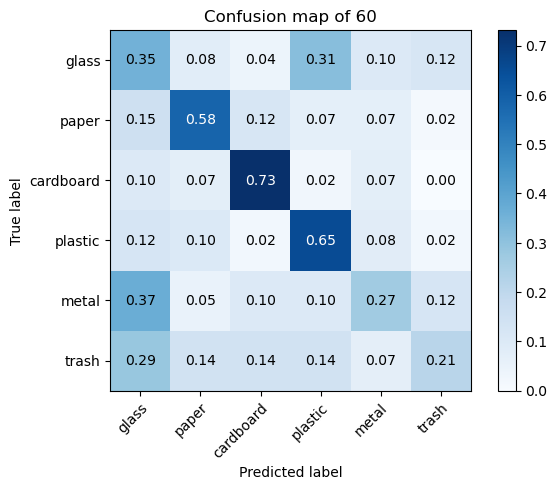

 56%|█████▌    | 5/9 [22:59<18:21, 275.39s/it]

#hidden units 60	Loss:  0.5400050862104898
#hidden units 60	Accuracy:  0.50390625


/Users/mehulgoel/anaconda3/envs/HackCMU/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/mehulgoel/Documents/HACKS-CMU_2023/Eco-Bin/src/helper_func.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(# ... and label them with the respective list entries


Normalized confusion matrix


<Figure size 640x480 with 0 Axes>

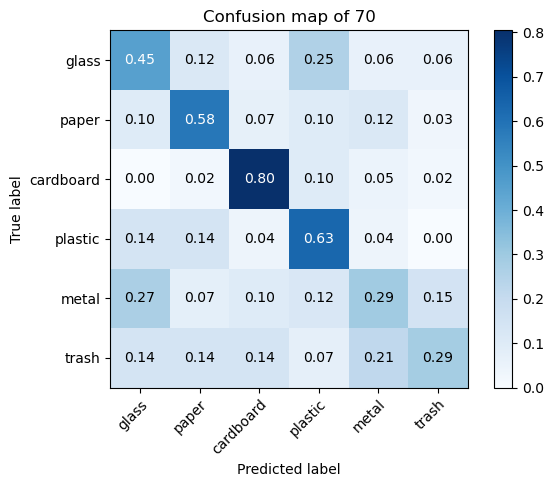

 67%|██████▋   | 6/9 [27:50<14:02, 280.90s/it]

#hidden units 70	Loss:  0.5721962447372351
#hidden units 70	Accuracy:  0.5390625


/Users/mehulgoel/anaconda3/envs/HackCMU/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/mehulgoel/Documents/HACKS-CMU_2023/Eco-Bin/src/helper_func.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(# ... and label them with the respective list entries


Normalized confusion matrix


<Figure size 640x480 with 0 Axes>

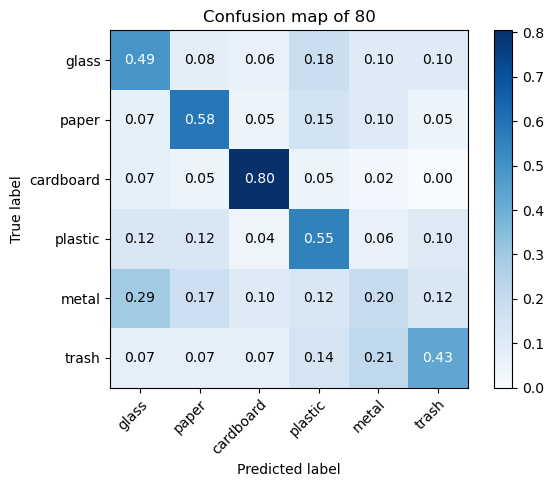

 78%|███████▊  | 7/9 [32:06<09:05, 272.68s/it]

#hidden units 80	Loss:  0.4358090982362272
#hidden units 80	Accuracy:  0.5234375


/Users/mehulgoel/anaconda3/envs/HackCMU/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/mehulgoel/Documents/HACKS-CMU_2023/Eco-Bin/src/helper_func.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(# ... and label them with the respective list entries


Normalized confusion matrix


<Figure size 640x480 with 0 Axes>

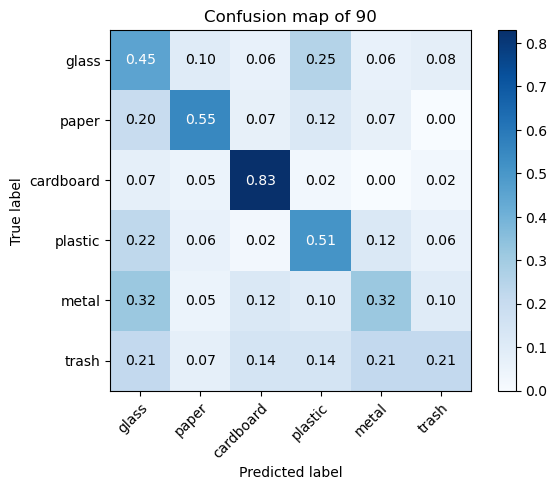

 89%|████████▉ | 8/9 [36:34<04:30, 270.98s/it]

#hidden units 90	Loss:  0.4969355350558169
#hidden units 90	Accuracy:  0.51171875


/Users/mehulgoel/anaconda3/envs/HackCMU/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/mehulgoel/Documents/HACKS-CMU_2023/Eco-Bin/src/helper_func.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(# ... and label them with the respective list entries


Normalized confusion matrix


<Figure size 640x480 with 0 Axes>

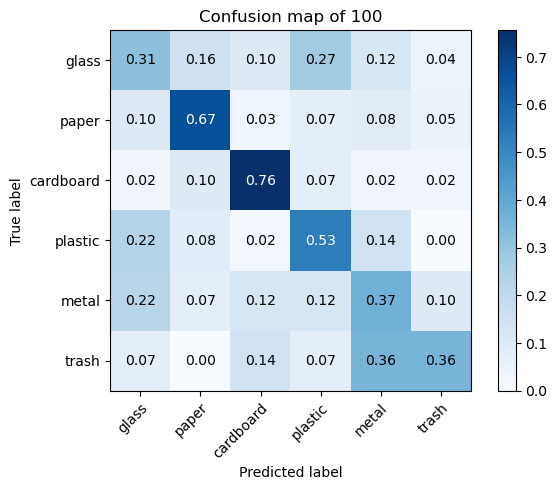

100%|██████████| 9/9 [41:10<00:00, 274.53s/it]

#hidden units 100	Loss:  0.6766015540693912
#hidden units 100	Accuracy:  0.51953125
Overall losses: [0.4824666892384081, 0.567371298944177, 0.8449556054322847, 0.512030643614902, 0.5400050862104898, 0.5721962447372351, 0.4358090982362272, 0.4969355350558169, 0.6766015540693912]
Overall accuracies: [0.5078125, 0.4609375, 0.4921875, 0.515625, 0.50390625, 0.5390625, 0.5234375, 0.51171875, 0.51953125]


['mlp_trained_model.pkl']

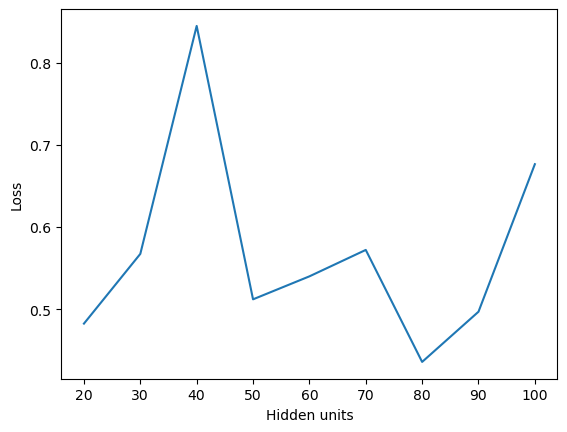

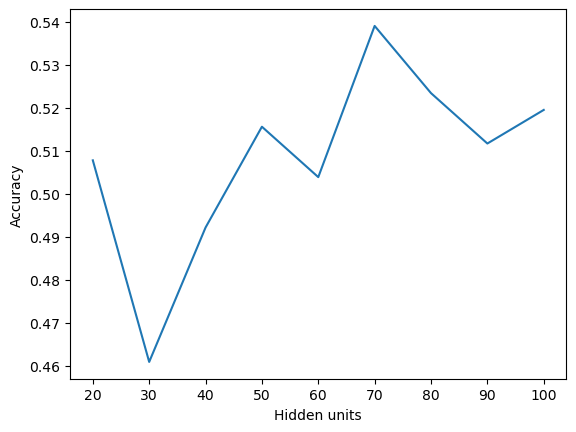

In [10]:
from sklearn.neural_network import MLPClassifier

hidden_layer_range = [20, 30, 40, 50, 60, 70, 80, 90, 100]

losses = []
accuracies = []

for i in tqdm((hidden_layer_range)):
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=20)
    clf.fit(r_training_data, training_labels)
    loss = clf.loss_
    losses.append(loss)
    
    plt.figure()
    predict = clf.predict(r_testing_data)
    predict = torch.from_numpy(predict)
    generate_confusion_matrix(testing_labels, predict, classified_name, normalize=True)
    plt.title("Confusion map of " + str(i))
    plt.show()
    matches = testing_labels[testing_labels==predict]
    accuracy = matches.shape[0]/testing_labels.shape[0]
    accuracies.append(accuracy)
    print("#hidden units "+ str(i) + "\tLoss: ", loss)
    print("#hidden units "+ str(i) + "\tAccuracy: ", accuracy)
    
plt.figure()
plt.xlabel("Hidden units")
plt.ylabel("Loss")
plt.plot(hidden_layer_range, losses)
print("Overall losses:", losses)

plt.figure()
plt.xlabel("Hidden units")
plt.ylabel("Accuracy")
plt.plot(hidden_layer_range, accuracies)
print("Overall accuracies:", accuracies)

trained_model_filename = 'mlp_trained_model.pkl'
joblib.dump(clf, trained_model_filename)

In the following area, we use the best number of hidden unit output with different numbers of hidden layers and observe the result

In [18]:

num_hidden_unit = hidden_layer_range[np.argmax(accuracies)]

num_hidden_layer = ((num_hidden_unit),
                    (num_hidden_unit,num_hidden_unit),
                    (num_hidden_unit,num_hidden_unit,num_hidden_unit),
                    (num_hidden_unit,num_hidden_unit,num_hidden_unit,num_hidden_unit))

losses = []
accuracies = []

for i in tqdm((num_hidden_layer)):
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=i)
    clf.fit(r_training_data, training_labels)
    loss = clf.loss_
    losses.append(loss)
    
    plt.figure()
    predict = clf.predict(r_testing_data)
    predict = torch.from_numpy(predict)
    generate_confusion_matrix(testing_labels, predict, classified_name, normalize=True)
    plt.title("Confusion map of " + str(i))
    plt.show()
    matches = testing_labels[testing_labels==predict]
    accuracy = matches.shape[0]/testing_labels.shape[0]
    accuracies.append(accuracy)
    print("#hidden layer "+ str(i) + "\tLoss: ", loss)
    print("#hidden layer "+ str(i) + "\tAccuracy: ", accuracy)
    
plt.figure()
plt.xlabel("Hidden layers")
plt.ylabel("Loss")
plt.plot(np.arange(len(num_hidden_layer)), losses)
print("Overall losses:", losses)

plt.figure()
plt.xlabel("Hidden layers")
plt.ylabel("Accuracy")
plt.plot(np.arange(1, len(num_hidden_layer)+1), accuracies)
print("Overall accuracies:", accuracies)


ValueError: attempt to get argmax of an empty sequence

In [31]:
# Load the trained model
loaded_model = joblib.load('mlp_trained_model.pkl')  # Replace with the actual filename

# Load and preprocess the image
image_path = 'garbage-classification/data/plastic100.jpg'  # Replace with the actual image path
image = Image.open(image_path)  # Load the image using PIL

# Perform any necessary preprocessing here, e.g., resizing, normalizing, etc.
# Example: image = image.resize((width, height))
# Example: image = np.array(image) / 255.0  # Normalize pixel values

# Convert the PIL image to a NumPy array
# Perform any necessary preprocessing here, e.g., resizing, normalizing, etc.
# Example: image = image.resize((width, height))
# Example: image = np.array(image) / 255.0  # Normalize pixel values

# Flatten or reshape the image to match the expected input size
input_size = (128, 128)  # Adjust to match your model's expected input size
image = image.resize(input_size)
image_data = np.array(image).reshape(1, -1)  # Reshape to a 1D array

# Make a prediction
predicted_class = loaded_model.predict(image_data)  # Use the reshaped image for prediction


# Use the predicted_class for further processing or display
print("Predicted Class:", predicted_class)

Predicted Class: [3]
